In [3]:
pip install numpy librosa pretty_midi matplotlib torch tqdm soundfile pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import librosa
import pretty_midi
import numpy as np
from pathlib import Path
import tensorflow as tf

# Directory setup
base_dir = Path("/nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0")
output_dir = Path("./preprocessed_output_all_480_minimal")
mel_output_dir = output_dir / "mel_spectrograms"
piano_roll_output_dir = output_dir / "piano_rolls"
output_dir.mkdir(exist_ok=True)
mel_output_dir.mkdir(exist_ok=True)
piano_roll_output_dir.mkdir(exist_ok=True)

# Parameters
sr = 16000
hop_length = 512
n_fft = 2048
n_mels = 229
n_pitches = 88
segment_length = 480  # Fixed input size for CNN

# Preprocessing functions
def preprocess_wav_to_mel(wav_path, midi_duration):
    audio, _ = librosa.load(str(wav_path), sr=sr)
    # Trim audio to MIDI duration
    max_samples = int(midi_duration * sr)
    audio = audio[:max_samples] if len(audio) > max_samples else audio
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    expected_T = (len(audio) - n_fft) // hop_length + 1
    if S_db.shape[1] > expected_T:
        S_db = S_db[:, :expected_T]
    return S_db

def preprocess_midi_to_piano_roll(midi_path, T_target, frame_rate):
    midi = pretty_midi.PrettyMIDI(str(midi_path))
    piano_roll = midi.get_piano_roll(fs=frame_rate)
    piano_roll = piano_roll[21:109, :]  # 88 pitches
    if piano_roll.shape[1] < T_target:
        padding = np.zeros((n_pitches, T_target - piano_roll.shape[1]), dtype=np.uint8)
        piano_roll = np.hstack((piano_roll, padding))
    elif piano_roll.shape[1] > T_target:
        piano_roll = piano_roll[:, :T_target]
    piano_roll = (piano_roll > 0).astype(np.uint8)
    return piano_roll

# Segment data into fixed-length chunks
def segment_data(data, segment_length, axis=1):
    T = data.shape[axis]
    if T < segment_length:
        pad_width = [(0, 0)] * len(data.shape)
        pad_width[axis] = (0, segment_length - T)
        return [np.pad(data, pad_width, mode='constant', constant_values=0)]
    segments = []
    for start in range(0, T, segment_length):
        end = min(start + segment_length, T)
        segment = data[:, start:end] if axis == 1 else data[start:end, :]
        if segment.shape[axis] < segment_length:
            pad_width = [(0, 0)] * len(segment.shape)
            pad_width[axis] = (0, segment_length - segment.shape[axis])
            segment = np.pad(segment, pad_width, mode='constant', constant_values=0)
        segments.append(segment)
    return segments

# Collect all WAV and MIDI files across subfolders
wav_files = []
for year_dir in base_dir.iterdir():
    if year_dir.is_dir():
        wav_files.extend(sorted([f for f in year_dir.glob("*.wav") if f.with_suffix(".midi").exists()]))
midi_files = [f.with_suffix(".midi") for f in wav_files]

print(f"Found {len(wav_files)} files across all subfolders in {base_dir}")

# Process all files with minimal validation
segment_counts = []  # Track number of segments per file
skipped_files = 0
for i, (wav_file, midi_file) in enumerate(zip(wav_files, midi_files)):
    print(f"Processing file {i+1}/{len(wav_files)}: {wav_file.name} (from {wav_file.parent.name})")
    
    # Get MIDI duration
    try:
        midi = pretty_midi.PrettyMIDI(str(midi_file))
        midi_duration = midi.get_end_time()
    except Exception as e:
        print(f"  Skipping {wav_file.name}: Error reading MIDI file ({e})")
        skipped_files += 1
        continue
    
    # Mel spectrogram
    try:
        S_db = preprocess_wav_to_mel(wav_file, midi_duration)
        if S_db.shape[1] < segment_length:
            print(f"  Skipping {wav_file.name}: Too short (< 480 frames)")
            skipped_files += 1
            continue
    except Exception as e:
        print(f"  Skipping {wav_file.name}: Error processing WAV file ({e})")
        skipped_files += 1
        continue
    
    # Piano-roll
    frame_rate = sr / hop_length
    piano_roll = preprocess_midi_to_piano_roll(midi_file, S_db.shape[1], frame_rate)
    
    # Segment into 480-frame chunks
    mel_segments = segment_data(S_db, segment_length, axis=1)
    piano_roll_segments = segment_data(piano_roll, segment_length, axis=1)
    
    # Minimal shape validation for the first segment
    assert mel_segments[0].shape == (n_mels, segment_length), f"Mel shape mismatch: {mel_segments[0].shape}"
    assert piano_roll_segments[0].shape == (n_pitches, segment_length), f"Piano-Roll shape mismatch: {piano_roll_segments[0].shape}"
    
    # Save segments and count
    segment_count = len(mel_segments)
    segment_counts.append(segment_count)
    for j in range(segment_count):
        mel_output_path = mel_output_dir / f"{wav_file.stem}_seg{j:04d}_mel.npy"
        piano_roll_output_path = piano_roll_output_dir / f"{midi_file.stem}_seg{j:04d}_piano_roll.npy"
        np.save(mel_output_path, mel_segments[j])
        np.save(piano_roll_output_path, piano_roll_segments[j])
    print(f"  Saved {segment_count} segments")

# Summary of processing
total_segments = sum(segment_counts)
print(f"\nProcessing Summary:")
print(f"Total files processed: {len(wav_files) - skipped_files}")
print(f"Total files skipped: {skipped_files}")
print(f"Total segments generated: {total_segments}")
print(f"Mel spectrograms saved in: {mel_output_dir}")
print(f"Piano-rolls saved in: {piano_roll_output_dir}")

2025-03-14 23:41:15.582597: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 23:41:16.023006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741975876.178176   32621 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741975876.185638   32621 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 23:41:16.727828: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Found 1276 files across all subfolders in /nfsshare/selva/maestro-v3.0.0/maestro-v3.0.0
Processing file 1/1276: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav (from 2004)
  Saved 64 segments
Processing file 2/1276: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.wav (from 2004)
  Saved 18 segments
Processing file 3/1276: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.wav (from 2004)
  Saved 13 segments
Processing file 4/1276: MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.wav (from 2004)
  Saved 21 segments
Processing file 5/1276: MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.wav (from 2004)
  Saved 92 segments
Processing file 6/1276: MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.wav (from 2004)
  Saved 22 segments
Processing file 7/1276: MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_

  Saved 35 segments
Processing file 59/1276: MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_01_Track01_wav.wav (from 2004)
  Saved 67 segments
Processing file 60/1276: MIDI-Unprocessed_XP_04_R2_2004_01_ORIG_MID--AUDIO_04_R2_2004_02_Track02_wav.wav (from 2004)
  Saved 85 segments
Processing file 61/1276: MIDI-Unprocessed_XP_06_R1_2004_01_ORIG_MID--AUDIO_06_R1_2004_01_Track01_wav.wav (from 2004)
  Saved 157 segments
Processing file 62/1276: MIDI-Unprocessed_XP_06_R1_2004_02-03_ORIG_MID--AUDIO_06_R1_2004_05_Track05_wav.wav (from 2004)
  Saved 49 segments
Processing file 63/1276: MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_01_Track01_wav.wav (from 2004)
  Saved 46 segments
Processing file 64/1276: MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_02_Track02_wav.wav (from 2004)
  Saved 35 segments
Processing file 65/1276: MIDI-Unprocessed_XP_06_R2_2004_01_ORIG_MID--AUDIO_06_R2_2004_03_Track03_wav.wav (from 2004)
  Saved 49 segments
Processing file 6

  Saved 137 segments
Processing file 119/1276: MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_01_Track01_wav.wav (from 2004)
  Saved 30 segments
Processing file 120/1276: MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_02_Track02_wav.wav (from 2004)
  Saved 31 segments
Processing file 121/1276: MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_03_Track03_wav.wav (from 2004)
  Saved 46 segments
Processing file 122/1276: MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_01_Track01_wav.wav (from 2004)
  Saved 50 segments
Processing file 123/1276: MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_02_Track02_wav.wav (from 2004)
  Saved 29 segments
Processing file 124/1276: MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_03_Track03_wav.wav (from 2004)
  Saved 45 segments
Processing file 125/1276: MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.wav (from 2004)
  Saved 57 segments
Processing fi

  Saved 61 segments
Processing file 179/1276: MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_02_Track02_wav.wav (from 2006)
  Saved 39 segments
Processing file 180/1276: MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_03_Track03_wav.wav (from 2006)
  Saved 51 segments
Processing file 181/1276: MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav.wav (from 2006)
  Saved 92 segments
Processing file 182/1276: MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_03_Track03_wav.wav (from 2006)
  Saved 83 segments
Processing file 183/1276: MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_05_Track05_wav.wav (from 2006)
  Saved 60 segments
Processing file 184/1276: MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_01_Track01_wav.wav (from 2006)
  Saved 22 segments
Processing file 185/1276: MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_02_Track02_wav.wav (from 2006)
  Saved 73 segments
Processing file 186/

  Saved 123 segments
Processing file 239/1276: MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_01_Track01_wav.wav (from 2006)
  Saved 43 segments
Processing file 240/1276: MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_02_Track02_wav.wav (from 2006)
  Saved 48 segments
Processing file 241/1276: MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_03_Track03_wav.wav (from 2006)
  Saved 28 segments
Processing file 242/1276: MIDI-Unprocessed_23_R2_2006_01_ORIG_MID--AUDIO_23_R2_2006_04_Track04_wav.wav (from 2006)
  Saved 18 segments
Processing file 243/1276: MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_01_Track01_wav.wav (from 2006)
  Saved 62 segments
Processing file 244/1276: MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_02_Track02_wav.wav (from 2006)
  Saved 45 segments
Processing file 245/1276: MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_03_Track03_wav.wav (from 2006)
  Saved 28 segments
Processing file 246/1276:

  Saved 7 segments
Processing file 302/1276: MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--3.wav (from 2008)
  Saved 9 segments
Processing file 303/1276: MIDI-Unprocessed_07_R2_2008_01-05_ORIG_MID--AUDIO_07_R2_2008_wav--4.wav (from 2008)
  Saved 28 segments
Processing file 304/1276: MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--1.wav (from 2008)
  Saved 16 segments
Processing file 305/1276: MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--2.wav (from 2008)
  Saved 45 segments
Processing file 306/1276: MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--3.wav (from 2008)
  Saved 12 segments
Processing file 307/1276: MIDI-Unprocessed_07_R3_2008_01-05_ORIG_MID--AUDIO_07_R3_2008_wav--4.wav (from 2008)
  Saved 14 segments
Processing file 308/1276: MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AUDIO_08_R1_2008_wav--1.wav (from 2008)
  Saved 11 segments
Processing file 309/1276: MIDI-Unprocessed_08_R1_2008_01-05_ORIG_MID--AU

  Saved 41 segments
Processing file 366/1276: MIDI-Unprocessed_12_R3_2008_01-04_ORIG_MID--AUDIO_12_R3_2008_wav--3.wav (from 2008)
  Saved 12 segments
Processing file 367/1276: MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--1.wav (from 2008)
  Saved 16 segments
Processing file 368/1276: MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--2.wav (from 2008)
  Saved 13 segments
Processing file 369/1276: MIDI-Unprocessed_13_R1_2008_01-04_ORIG_MID--AUDIO_13_R1_2008_wav--4.wav (from 2008)
  Saved 44 segments
Processing file 370/1276: MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--1.wav (from 2008)
  Saved 15 segments
Processing file 371/1276: MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--2.wav (from 2008)
  Saved 18 segments
Processing file 372/1276: MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--AUDIO_14_R1_2008_wav--3.wav (from 2008)
  Saved 12 segments
Processing file 373/1276: MIDI-Unprocessed_14_R1_2008_01-05_ORIG_MID--

  Saved 77 segments
Processing file 427/1276: MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_01_WAV.wav (from 2009)
  Saved 32 segments
Processing file 428/1276: MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_02_WAV.wav (from 2009)
  Saved 31 segments
Processing file 429/1276: MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_03_WAV.wav (from 2009)
  Saved 11 segments
Processing file 430/1276: MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_04_WAV.wav (from 2009)
  Saved 34 segments
Processing file 431/1276: MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_01_WAV.wav (from 2009)
  Saved 44 segments
Processing file 432/1276: MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_02_WAV.wav (from 2009)
  Saved 22 segments
Processing file 433/1276: MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_03_WAV.wav (from 2009)
  Saved 16 segments
Proce

  Saved 26 segments
Processing file 486/1276: MIDI-Unprocessed_16_R1_2009_01-02_ORIG_MID--AUDIO_16_R1_2009_16_R1_2009_01_WAV.wav (from 2009)
  Saved 100 segments
Processing file 487/1276: MIDI-Unprocessed_16_R1_2009_01-02_ORIG_MID--AUDIO_16_R1_2009_16_R1_2009_02_WAV.wav (from 2009)
  Saved 46 segments
Processing file 488/1276: MIDI-Unprocessed_16_R1_2009_03-06_ORIG_MID--AUDIO_16_R1_2009_16_R1_2009_03_WAV.wav (from 2009)
  Saved 41 segments
Processing file 489/1276: MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_01_WAV.wav (from 2009)
  Saved 47 segments
Processing file 490/1276: MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_02_WAV.wav (from 2009)
  Saved 36 segments
Processing file 491/1276: MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_03_WAV.wav (from 2009)
  Saved 21 segments
Processing file 492/1276: MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_04_WAV.wav (from 2009)
  Saved 35 segments
Proc

  Saved 39 segments
Processing file 549/1276: MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.wav (from 2011)
  Saved 36 segments
Processing file 550/1276: MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_03_Track03_wav.wav (from 2011)
  Saved 24 segments
Processing file 551/1276: MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_04_Track04_wav.wav (from 2011)
  Saved 44 segments
Processing file 552/1276: MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_05_Track05_wav.wav (from 2011)
  Saved 14 segments
Processing file 553/1276: MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_06_Track06_wav.wav (from 2011)
  Saved 53 segments
Processing file 554/1276: MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_08_Track08_wav.wav (from 2011)
  Saved 8 segments
Processing file 555/1276: MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_09_Track09_wav.wav (from 2011)
  Saved 13 segments
Processing file 556/1276: MIDI-Unprocessed_05_R1_2011_MID--AUDIO_R1-D2_10_Track10_wav.wav (from 2011)
  Saved 13 segments
Proce

  Saved 15 segments
Processing file 617/1276: MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_14_Track14_wav.wav (from 2011)
  Saved 26 segments
Processing file 618/1276: MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav.wav (from 2011)
  Saved 24 segments
Processing file 619/1276: MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_08_Track08_wav.wav (from 2011)
  Saved 54 segments
Processing file 620/1276: MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_09_Track09_wav.wav (from 2011)
  Saved 17 segments
Processing file 621/1276: MIDI-Unprocessed_16_R3_2011_MID--AUDIO_R3-D5_02_Track02_wav.wav (from 2011)
  Saved 44 segments
Processing file 622/1276: MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav.wav (from 2011)
  Saved 11 segments
Processing file 623/1276: MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_03_Track03_wav.wav (from 2011)
  Saved 23 segments
Processing file 624/1276: MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_04_Track04_wav.wav (from 2011)
  Saved 13 segments
Proc

  Saved 30 segments
Processing file 685/1276: ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--2.wav (from 2013)
  Saved 53 segments
Processing file 686/1276: ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_07_R3_2013_wav--3.wav (from 2013)
  Saved 36 segments
Processing file 687/1276: ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--1.wav (from 2013)
  Saved 40 segments
Processing file 688/1276: ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--2.wav (from 2013)
  Saved 54 segments
Processing file 689/1276: ORIG-MIDI_01_7_10_13_Group_MID--AUDIO_08_R3_2013_wav--3.wav (from 2013)
  Saved 34 segments
Processing file 690/1276: ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--1.wav (from 2013)
  Saved 29 segments
Processing file 691/1276: ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--2.wav (from 2013)
  Saved 22 segments
Processing file 692/1276: ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_01_R1_2013_wav--3.wav (from 2013)
  Saved 20 segments
Processing file 693/1276: ORIG-MIDI_

  Saved 15 segments
Processing file 755/1276: ORIG-MIDI_02_7_6_13_Group__MID--AUDIO_08_R1_2013_wav--5.wav (from 2013)
  Saved 11 segments
Processing file 756/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--1.wav (from 2013)
  Saved 21 segments
Processing file 757/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--2.wav (from 2013)
  Saved 22 segments
Processing file 758/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--3.wav (from 2013)
  Saved 14 segments
Processing file 759/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_15_R1_2013_wav--4.wav (from 2013)
  Saved 20 segments
Processing file 760/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--1.wav (from 2013)
  Saved 12 segments
Processing file 761/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--2.wav (from 2013)
  Saved 28 segments
Processing file 762/1276: ORIG-MIDI_02_7_7_13_Group__MID--AUDIO_16_R1_2013_wav--3.wav (from 2013)
  Saved 16 segments
Processing file 763/1276: ORIG-MIDI_

  Saved 10 segments
Processing file 824/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--2.wav (from 2014)
  Saved 79 segments
Processing file 825/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--3.wav (from 2014)
  Saved 74 segments
Processing file 826/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--4.wav (from 2014)
  Saved 19 segments
Processing file 827/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--5.wav (from 2014)
  Saved 13 segments
Processing file 828/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1.wav (from 2014)
  Saved 49 segments
Processing file 829/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2.wav (from 2014)
  Saved 14 segments
Processing file 830/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--4.wav (from 2014)
  Saved 17 segments
Processing file 831/1276: MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--5.wav (from 2014)
  Saved 8 segments
Proce

  Saved 72 segments
Processing file 891/1276: MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--3.wav (from 2014)
  Saved 10 segments
Processing file 892/1276: MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--4.wav (from 2014)
  Saved 15 segments
Processing file 893/1276: MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--5.wav (from 2014)
  Saved 31 segments
Processing file 894/1276: MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_19_R2_2014_wav.wav (from 2014)
  Saved 160 segments
Processing file 895/1276: MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_20_R2_2014_wav.wav (from 2014)
  Saved 104 segments
Processing file 896/1276: MIDI-UNPROCESSED_19-20-21_R2_2014_MID--AUDIO_21_R2_2014_wav.wav (from 2014)
  Saved 116 segments
Processing file 897/1276: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--1.wav (from 2014)
  Saved 40 segments
Processing file 898/1276: MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO_19_R1_2014_wav--2.wav (from 2014)
  Saved 104 segments


  Saved 23 segments
Processing file 957/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--2.wav (from 2015)
  Saved 8 segments
Processing file 958/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_10_R1_2015_wav--3.wav (from 2015)
  Saved 82 segments
Processing file 959/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--1.wav (from 2015)
  Saved 60 segments
Processing file 960/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--2.wav (from 2015)
  Saved 14 segments
Processing file 961/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--3.wav (from 2015)
  Saved 10 segments
Processing file 962/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--4.wav (from 2015)
  Saved 18 segments
Processing file 963/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_11_R1_2015_wav--5.wav (from 2015)
  Saved 8 segments
Processing file 964/1276: MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_12_R1_2015_w

  Saved 45 segments
Processing file 1020/1276: MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--3.wav (from 2015)
  Saved 28 segments
Processing file 1021/1276: MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--1.wav (from 2015)
  Saved 45 segments
Processing file 1022/1276: MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--2.wav (from 2015)
  Saved 24 segments
Processing file 1023/1276: MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--4.wav (from 2015)
  Saved 54 segments
Processing file 1024/1276: MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--1.wav (from 2015)
  Saved 38 segments
Processing file 1025/1276: MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--2.wav (from 2015)
  Saved 23 segments
Processing file 1026/1276: MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--3.wav (from 2015)
  Saved 49 segments
Processing file 1027/1276: MIDI-U

  Saved 25 segments
Processing file 1080/1276: MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--3.wav (from 2017)
  Saved 32 segments
Processing file 1081/1276: MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--4.wav (from 2017)
  Saved 31 segments
Processing file 1082/1276: MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--1.wav (from 2017)
  Saved 10 segments
Processing file 1083/1276: MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--2.wav (from 2017)
  Saved 21 segments
Processing file 1084/1276: MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--3.wav (from 2017)
  Saved 15 segments
Processing file 1085/1276: MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--4.wav (from 2017)
  Saved 42 segments
Processing file 1086/1276: MIDI-Unprocessed_051_PIANO051_MID--AUDIO-split_07-06-17_Piano-e_3-02_wav--5.wav (from 2017)
  Saved 16 segments
Process

  Saved 19 segments
Processing file 1139/1276: MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--1.wav (from 2017)
  Saved 21 segments
Processing file 1140/1276: MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--2.wav (from 2017)
  Saved 19 segments
Processing file 1141/1276: MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--3.wav (from 2017)
  Saved 8 segments
Processing file 1142/1276: MIDI-Unprocessed_067_PIANO067_MID--AUDIO-split_07-07-17_Piano-e_3-03_wav--4.wav (from 2017)
  Saved 28 segments
Processing file 1143/1276: MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--1.wav (from 2017)
  Saved 19 segments
Processing file 1144/1276: MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--2.wav (from 2017)
  Saved 6 segments
Processing file 1145/1276: MIDI-Unprocessed_070_PIANO070_MID--AUDIO-split_07-08-17_Piano-e_1-02_wav--3.wav (from 2017)
  Saved 48 segments
Processin

  Saved 133 segments
Processing file 1201/1276: MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--4.wav (from 2018)
  Saved 17 segments
Processing file 1202/1276: MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--5.wav (from 2018)
  Saved 11 segments
Processing file 1203/1276: MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--1.wav (from 2018)
  Saved 53 segments
Processing file 1204/1276: MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--2.wav (from 2018)
  Saved 46 segments
Processing file 1205/1276: MIDI-Unprocessed_Recital12_MID--AUDIO_12_R1_2018_wav--3.wav (from 2018)
  Saved 42 segments
Processing file 1206/1276: MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--1.wav (from 2018)
  Saved 70 segments
Processing file 1207/1276: MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2.wav (from 2018)
  Saved 100 segments
Processing file 1208/1276: MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--3.wav (from 2018)
  Saved 107 segments
Processing fil

  Saved 124 segments
Processing file 1269/1276: MIDI-Unprocessed_Schubert10-12_MID--AUDIO_18_R2_2018_wav.wav (from 2018)
  Saved 130 segments
Processing file 1270/1276: MIDI-Unprocessed_Schubert10-12_MID--AUDIO_20_R2_2018_wav.wav (from 2018)
  Saved 153 segments
Processing file 1271/1276: MIDI-Unprocessed_Schubert4-6_MID--AUDIO_08_R2_2018_wav.wav (from 2018)
  Saved 114 segments
Processing file 1272/1276: MIDI-Unprocessed_Schubert4-6_MID--AUDIO_09_R2_2018_wav.wav (from 2018)
  Saved 167 segments
Processing file 1273/1276: MIDI-Unprocessed_Schubert4-6_MID--AUDIO_10_R2_2018_wav.wav (from 2018)
  Saved 158 segments
Processing file 1274/1276: MIDI-Unprocessed_Schubert7-9_MID--AUDIO_11_R2_2018_wav.wav (from 2018)
  Saved 107 segments
Processing file 1275/1276: MIDI-Unprocessed_Schubert7-9_MID--AUDIO_15_R2_2018_wav.wav (from 2018)
  Saved 136 segments
Processing file 1276/1276: MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav.wav (from 2018)
  Saved 115 segments

Processing Summary:
To

In [7]:
import os
import shutil
import numpy as np
from pathlib import Path
from collections import defaultdict

# Input directories (from previous preprocessing)
base_output_dir = Path("./preprocessed_output_all_480_minimal")
mel_input_dir = base_output_dir / "mel_spectrograms"
piano_roll_input_dir = base_output_dir / "piano_rolls"

# Output directories for train, val, test splits
mel_train_dir = mel_input_dir / "train"
mel_val_dir = mel_input_dir / "val"
mel_test_dir = mel_input_dir / "test"
piano_roll_train_dir = piano_roll_input_dir / "train"
piano_roll_val_dir = piano_roll_input_dir / "val"
piano_roll_test_dir = piano_roll_input_dir / "test"

# Create directories
for d in [mel_train_dir, mel_val_dir, mel_test_dir, piano_roll_train_dir, piano_roll_val_dir, piano_roll_test_dir]:
    d.mkdir(exist_ok=True)

# Step 1: Collect all Mel spectrogram files and group by original file
mel_files = sorted(list(mel_input_dir.glob("*_mel.npy")))
print(f"Total Mel spectrogram segments: {len(mel_files)}")

# Group segments by original file (based on filename before "_segXXXX_mel.npy")
file_groups = defaultdict(list)
for mel_file in mel_files:
    # Extract the base filename (e.g., "MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav")
    base_name = mel_file.stem.split("_seg")[0]
    file_groups[base_name].append(mel_file)

# Step 2: Split files into train, val, test (80-10-10)
file_names = list(file_groups.keys())
np.random.seed(42)  # For reproducibility
np.random.shuffle(file_names)

total_files = len(file_names)
train_split = int(0.8 * total_files)  # 80%
val_split = int(0.1 * total_files)    # 10%
test_split = total_files - train_split - val_split  # Remaining 10%

train_files = file_names[:train_split]
val_files = file_names[train_split:train_split + val_split]
test_files = file_names[train_split + val_split:]

print(f"Total files: {total_files}")
print(f"Train files: {len(train_files)} ({len(train_files)/total_files*100:.1f}%)")
print(f"Val files: {len(val_files)} ({len(val_files)/total_files*100:.1f}%)")
print(f"Test files: {len(test_files)} ({len(test_files)/total_files*100:.1f}%)")

# Step 3: Move Mel spectrograms and piano-rolls to appropriate directories
def move_files(file_list, split_name, mel_dest_dir, piano_roll_dest_dir):
    mel_count = 0
    piano_roll_count = 0
    for base_name in file_list:
        # Move Mel spectrograms
        mel_segments = file_groups[base_name]
        for mel_file in mel_segments:
            dest_path = mel_dest_dir / mel_file.name
            shutil.move(str(mel_file), str(dest_path))
            mel_count += 1
        
        # Move corresponding piano-rolls
        piano_roll_segments = [piano_roll_input_dir / mel_file.name.replace("_mel.npy", "_piano_roll.npy") for mel_file in mel_segments]
        for piano_roll_file in piano_roll_segments:
            if piano_roll_file.exists():
                dest_path = piano_roll_dest_dir / piano_roll_file.name
                shutil.move(str(piano_roll_file), str(dest_path))
                piano_roll_count += 1
            else:
                print(f"Warning: Piano-roll file {piano_roll_file} not found for {base_name}")
    
    print(f"\nMoved to {split_name}:")
    print(f"  Mel spectrograms: {mel_count} segments")
    print(f"  Piano-rolls: {piano_roll_count} segments")

# Move files to train, val, test directories
move_files(train_files, "train", mel_train_dir, piano_roll_train_dir)
move_files(val_files, "val", mel_val_dir, piano_roll_val_dir)
move_files(test_files, "test", mel_test_dir, piano_roll_test_dir)

print("\nDataset split completed.")
print(f"Train: {mel_train_dir}, {piano_roll_train_dir}")
print(f"Val: {mel_val_dir}, {piano_roll_val_dir}")
print(f"Test: {mel_test_dir}, {piano_roll_test_dir}")

Total Mel spectrogram segments: 47268
Total files: 1276
Train files: 1020 (79.9%)
Val files: 127 (10.0%)
Test files: 129 (10.1%)

Moved to train:
  Mel spectrograms: 37993 segments
  Piano-rolls: 37993 segments

Moved to val:
  Mel spectrograms: 4113 segments
  Piano-rolls: 4113 segments

Moved to test:
  Mel spectrograms: 5162 segments
  Piano-rolls: 5162 segments

Dataset split completed.
Train: preprocessed_output_all_480_minimal/mel_spectrograms/train, preprocessed_output_all_480_minimal/piano_rolls/train
Val: preprocessed_output_all_480_minimal/mel_spectrograms/val, preprocessed_output_all_480_minimal/piano_rolls/val
Test: preprocessed_output_all_480_minimal/mel_spectrograms/test, preprocessed_output_all_480_minimal/piano_rolls/test


Frequency of Notes Played Across MIDI Range (21 to 127):
MIDI Pitch | Frequency (Number of Active Frames)
----------------------------------------
 21         |           40
 22         |          511
 23         |          359
 24         |          902
 25         |          603
 26         |         1685
 27         |          905
 28         |         3010
 29         |         3609
 30         |         6667
 31         |         8753
 32         |         9271
 33         |         9240
 34         |         8844
 35         |        12891
 36         |        12597
 37         |        15240
 38         |        16693
 39         |        17154
 40         |        16690
 41         |        20780
 42         |        19370
 43         |        30640
 44         |        24696
 45         |        28173
 46         |        33778
 47         |        30229
 48         |        32863
 49         |        38416
 50         |        47700
 51         |        46510
 52         |   

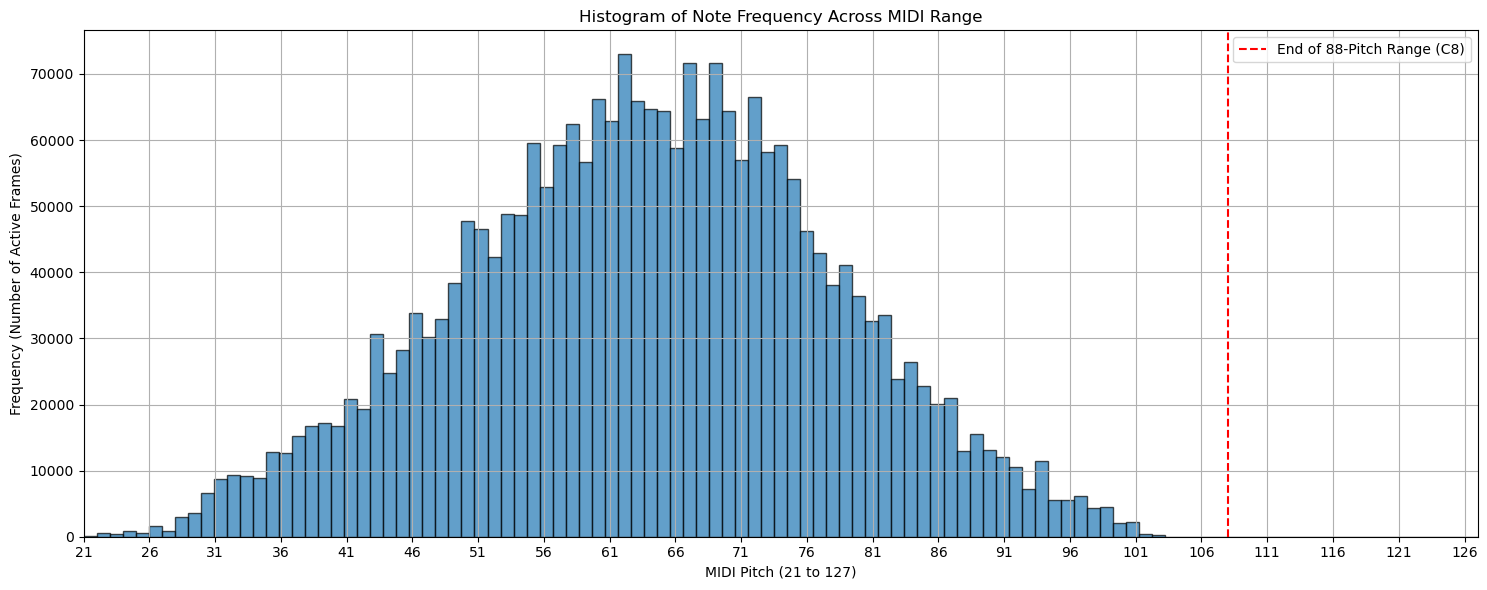

Note frequency data saved to 'note_frequency_distribution.csv'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming labels is already loaded with shape (1000, 88, 480)
# Calculate total frames per pitch across all segments
total_segments = labels.shape[0]  # Should be 1000 based on your code
total_frames_per_segment = labels.shape[2]  # Should be 480
total_frames = total_segments * total_frames_per_segment

# Initialize arrays to store positive counts for each MIDI pitch (21 to 127)
max_midi = 127
midi_counts = np.zeros(max_midi - 20)  # Array from MIDI 21 to 127 (107 elements)

# Sum the positive instances (note active) for each pitch in the 88-pitch range
for pitch in range(n_pitches):  # n_pitches = 88, corresponding to MIDI 21 to 108
    pitch_data = labels[:, pitch, :].flatten()  # All frames for this pitch
    midi_counts[pitch] = np.sum(pitch_data == 1)  # Count of active frames

# Convert counts to integers
midi_counts = midi_counts.astype(int)

# MIDI pitch numbers (21 to 127)
midi_pitches = np.arange(21, 128)

# Print the distribution summary
print("Frequency of Notes Played Across MIDI Range (21 to 127):")
print("MIDI Pitch | Frequency (Number of Active Frames)")
print("-" * 40)
for i in range(len(midi_pitches)):
    print(f"{midi_pitches[i]:3d}         | {midi_counts[i]:12d}")

# Create histogram
plt.figure(figsize=(15, 6))
plt.hist(midi_pitches, bins=len(midi_pitches), weights=midi_counts, edgecolor='black', alpha=0.7)
plt.xlabel('MIDI Pitch (21 to 127)')
plt.ylabel('Frequency (Number of Active Frames)')
plt.title('Histogram of Note Frequency Across MIDI Range')
plt.grid(True)
plt.xticks(np.arange(21, 128, 5))  # Show ticks every 5 MIDI notes
plt.xlim(21, 127)  # Set x-axis limits to match MIDI range
plt.tight_layout()

# Highlight the 88-pitch range used in the model (21 to 108)
plt.axvline(x=108, color='r', linestyle='--', label='End of 88-Pitch Range (C8)')
plt.legend()

# Save the plot
plt.savefig('note_frequency_histogram.png')
plt.show()

# Save the data to a CSV file
frequency_df = pd.DataFrame({
    'MIDI_Pitch': midi_pitches,
    'Frequency': midi_counts
})
frequency_df.to_csv('note_frequency_distribution.csv', index=False)
print("Note frequency data saved to 'note_frequency_distribution.csv'")

In [10]:
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr
import tensorflow as tf

# Directory for training piano-rolls
piano_roll_train_dir = Path("./preprocessed_output_all_480_minimal/piano_rolls/train")

# Parameters
n_pitches = 88
max_files_to_process = 37993
target_sparsity = (0.94, 0.96)  # Adjusted to hit ~0.95
threshold_range = np.linspace(0.15, 0.25, 21)  # Narrow range to target ~200 edges

# Step 1: Load training piano-rolls and compute note activations
piano_roll_files = sorted(list(piano_roll_train_dir.glob("*_piano_roll.npy")))
print(f"Found {len(piano_roll_files)} training piano-roll segments")
print(f"Processing up to {max_files_to_process} segments for efficiency")

total_frames = 0
processed_files = 0
for i, piano_roll_file in enumerate(piano_roll_files):
    if processed_files >= max_files_to_process:
        break
    piano_roll = np.load(piano_roll_file)
    total_frames += piano_roll.shape[1]
    processed_files += 1

note_activations = np.zeros((n_pitches, total_frames), dtype=np.uint8)
current_frame = 0
processed_files = 0
for i, piano_roll_file in enumerate(piano_roll_files):
    if processed_files >= max_files_to_process:
        break
    if i % 1000 == 0:
        print(f"Processing piano-roll {i}/{len(piano_roll_files)}")
    
    piano_roll = np.load(piano_roll_file)
    piano_roll = (piano_roll > 0).astype(np.uint8)
    num_frames = piano_roll.shape[1]
    note_activations[:, current_frame:current_frame + num_frames] = piano_roll
    current_frame += num_frames
    processed_files += 1

# Step 2: Compute Pearson Correlation Matrix
P_pearson = np.zeros((n_pitches, n_pitches), dtype=np.float32)
for i in range(n_pitches):
    for j in range(i + 1, n_pitches):
        if np.sum(note_activations[i, :]) == 0 or np.sum(note_activations[j, :]) == 0:
            corr = 0.0
        else:
            corr, _ = pearsonr(note_activations[i, :], note_activations[j, :])
        P_pearson[i, j] = corr
        P_pearson[j, i] = corr

print("\nPearson Correlation Matrix Statistics:")
print(f"Min value: {P_pearson.min():.4f}")
print(f"Max value: {P_pearson.max():.4f}")
print(f"Mean value: {P_pearson.mean():.4f}")

# Step 3: Find optimal threshold based on sparsity
def get_adjacency_matrix(P, tau):
    A = (P >= tau).astype(np.int32)
    np.fill_diagonal(A, 0)
    A_symmetric = np.logical_or(A, A.T).astype(np.int32)
    np.fill_diagonal(A_symmetric, 0)
    n_edges = np.sum(A_symmetric) // 2
    sparsity = np.sum(A_symmetric == 0) / (n_pitches * n_pitches)
    return A_symmetric, n_edges, sparsity

best_tau = None
best_A = None
best_edges = 0
best_sparsity = 0
for tau in threshold_range:
    A_pearson, edges_pearson, sparsity_pearson = get_adjacency_matrix(P_pearson, tau)
    if target_sparsity[0] <= sparsity_pearson <= target_sparsity[1]:
        best_tau = tau
        best_A = A_pearson
        best_edges = edges_pearson
        best_sparsity = sparsity_pearson
        break
    elif abs(sparsity_pearson - (target_sparsity[0] + target_sparsity[1]) / 2) < abs(best_sparsity - (target_sparsity[0] + target_sparsity[1]) / 2):
        best_tau = tau
        best_A = A_pearson
        best_edges = edges_pearson
        best_sparsity = sparsity_pearson

# Step 4: Validate final adjacency matrix
def validate_adjacency_matrix(A, label="", tau_used=None):
    n_nodes = A.shape[0]
    n_edges = np.sum(A) // 2
    sparsity = np.sum(A == 0) / (n_nodes * n_nodes)
    is_symmetric = np.array_equal(A, A.T)

    print(f"\nFinal Adjacency Matrix Validation ({label}, tau = {tau_used:.3f}):")
    print(f"Total number of nodes: {n_nodes} (should be 88)")
    print(f"Total number of edges: {n_edges}")
    print(f"Sparsity: {sparsity:.4f}")
    print(f"Is symmetric: {is_symmetric} (should be True)")

validate_adjacency_matrix(best_A, label="pearson", tau_used=best_tau)

# Convert to TensorFlow tensor
A_tf = tf.convert_to_tensor(best_A, dtype=tf.float32)

# Save adjacency matrix
np.save("adjacency_matrix_final.npy", best_A)
print("Adjacency matrix saved as adjacency_matrix_final.npy")

Found 37993 training piano-roll segments
Processing up to 37993 segments for efficiency
Processing piano-roll 0/37993
Processing piano-roll 1000/37993
Processing piano-roll 2000/37993
Processing piano-roll 3000/37993
Processing piano-roll 4000/37993
Processing piano-roll 5000/37993
Processing piano-roll 6000/37993
Processing piano-roll 7000/37993
Processing piano-roll 8000/37993
Processing piano-roll 9000/37993
Processing piano-roll 10000/37993
Processing piano-roll 11000/37993
Processing piano-roll 12000/37993
Processing piano-roll 13000/37993
Processing piano-roll 14000/37993
Processing piano-roll 15000/37993
Processing piano-roll 16000/37993
Processing piano-roll 17000/37993
Processing piano-roll 18000/37993
Processing piano-roll 19000/37993
Processing piano-roll 20000/37993
Processing piano-roll 21000/37993
Processing piano-roll 22000/37993
Processing piano-roll 23000/37993
Processing piano-roll 24000/37993
Processing piano-roll 25000/37993
Processing piano-roll 26000/37993
Process

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
import numpy as np

# Define constants (based on your logs)
n_mels = 229
frames_per_segment = 480
n_pitches = 88
d = 88  # Initial node feature dimension
d_prime = 768  # GCN output dimension

# Custom layers
class ClipLayer(layers.Layer):
    def __init__(self, min_value=-10, max_value=10, **kwargs):
        super(ClipLayer, self).__init__(**kwargs)
        self.min_value = min_value
        self.max_value = max_value

    def call(self, inputs):
        return tf.clip_by_value(inputs, self.min_value, self.max_value)

class TransposeLayer(layers.Layer):
    def __init__(self, perm, **kwargs):
        super(TransposeLayer, self).__init__(**kwargs)
        self.perm = perm

    def call(self, inputs):
        return tf.transpose(inputs, perm=self.perm)

class DotProductLayer(layers.Layer):
    def call(self, inputs):
        W, x = inputs
        return tf.matmul(W, x)

# Updated GCNLayer with modified layer normalization
class GCNLayer(layers.Layer):
    def __init__(self, units, activation="relu", **kwargs):
        super(GCNLayer, self).__init__(**kwargs)
        self.units = units
        self.dense = layers.Dense(
            units,
            kernel_regularizer=tf.keras.regularizers.l2(0.05),
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)
        )
        self.leaky_relu = layers.LeakyReLU(alpha=0.2)
        self.layer_norm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.7)

    def call(self, inputs, training=False):
        node_features, adjacency = inputs
        tf.print("GCNLayer Input - node_features shape:", node_features.shape, ", mean:", tf.reduce_mean(node_features))
        tf.print("GCNLayer Input - adjacency shape:", adjacency.shape, ", mean:", tf.reduce_mean(adjacency))
        x = self.dense(node_features)
        tf.print("GCNLayer After Dense - x shape:", x.shape, ", mean:", tf.reduce_mean(x))
        x = self.leaky_relu(x)
        x = self.dropout(x, training=training)
        x = self.layer_norm(x)  # Apply layer norm before graph conv and residual
        x_gcn = tf.matmul(adjacency, x)
        tf.print("GCNLayer After Graph Conv - x_gcn shape:", x_gcn.shape, ", mean:", tf.reduce_mean(x_gcn))
        x = x + x_gcn  # Residual connection after layer norm
        x = ClipLayer(min_value=-10, max_value=10)(x)
        tf.print("GCNLayer Output - x shape:", x.shape, ", mean:", tf.reduce_mean(x))
        return x

    def compute_output_shape(self, input_shape):
        node_features_shape = input_shape[0]
        return (node_features_shape[0], node_features_shape[1], self.units)

    def compute_output_spec(self, input_specs, **kwargs):
        node_features_spec = input_specs[0]
        output_shape = (node_features_spec.shape[0], node_features_spec.shape[1], self.units)
        return tf.keras.KerasTensor(shape=output_shape, dtype=node_features_spec.dtype)

# Build CNN-LSTM branch with corrected timesteps and dimensions
def build_cnn_lstm():
    inputs = layers.Input(shape=(n_mels, frames_per_segment, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)  # Output shape: (None, 114, 240, 32)
    # Reshape to (batch_size, timesteps, features) where timesteps=240
    x = layers.Permute((2, 1, 3))(x)  # (None, 240, 114, 32)
    x = layers.Reshape((240, 114 * 32))(x)  # (None, 240, 114*32)
    x = layers.LSTM(64, return_sequences=True)(x)  # (None, 240, 64)
    # Upsample to match frames_per_segment=480
    x = layers.UpSampling1D(size=2)(x)  # (None, 480, 64)
    cnn_lstm_features = layers.Dense(d_prime, activation='relu')(x)  # (None, 480, 768)
    cnn_lstm_pred = layers.Dense(n_pitches, activation='sigmoid')(cnn_lstm_features)  # (None, 480, 88)
    return Model(inputs=inputs, outputs={'cnn_lstm_features': cnn_lstm_features, 'cnn_lstm_pred': cnn_lstm_pred})

# Build GCN branch with updated scale
def build_gcn(scale):
    node_features = layers.Input(shape=(n_pitches, d), name="node_features")
    adjacency = layers.Input(shape=(n_pitches, n_pitches), name="adjacency", dtype=tf.float32)
    x = GCNLayer(d_prime)([node_features, adjacency])
    x = GCNLayer(d_prime)([x, adjacency])
    x = GCNLayer(d_prime)([x, adjacency])
    W = x
    W = layers.Dense(d_prime, activation='relu')(W)
    W = W * scale
    return Model(inputs=[node_features, adjacency], outputs={'gcn_pred': W}, name="gcn")

# Updated CRGCN model with TensorFlow operations wrapped in Lambda layers
class CRGCN(Model):
    def __init__(self, A):
        super(CRGCN, self).__init__()
        self.cnn_lstm = build_cnn_lstm()
        self.scale = tf.Variable(
            50.0, trainable=True, name='gcn_output_scale', dtype=tf.float32,
            constraint=lambda x: tf.maximum(x, 10.0)  # Increased initial value with constraint
        )
        self.gcn = build_gcn(self.scale)
        self.A = A
        self.transpose_layer = TransposeLayer(perm=[0, 2, 1])
        self.dot_product_layer = DotProductLayer()
        self.H0 = self.add_weight(
            name="H0",
            shape=(n_pitches, d),
            initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True
        )
        self.H0_transform = layers.Dense(d, activation='relu')
        self.feature_projection = layers.Dense(n_pitches, activation='relu')
        self.feature_projection_d_prime = layers.Dense(d_prime, activation='relu')

    def call(self, inputs, training=False):
        spectrogram = inputs
        tf.print("Input spectrogram shape:", spectrogram.shape)
        tf.debugging.assert_equal(
            tf.shape(spectrogram)[-3:],
            [n_mels, frames_per_segment, 1],
            message="Input spectrogram shape does not match expected dimensions"
        )
        cnn_lstm_outputs = self.cnn_lstm(spectrogram)
        x = cnn_lstm_outputs['cnn_lstm_features']
        cnn_lstm_pred = cnn_lstm_outputs['cnn_lstm_pred']
        cnn_lstm_features_projected = self.feature_projection(x)
        cnn_lstm_features_projected = self.transpose_layer(cnn_lstm_features_projected)
        cnn_lstm_features_projected = self.feature_projection_d_prime(cnn_lstm_features_projected)
        
        x = self.transpose_layer(x)  # Shape: (batch_size, d_prime, frames_per_segment)
        # Extract batch size using Lambda layer
        batch_size = layers.Lambda(lambda x: tf.shape(x)[0])(spectrogram)
        # Expand and tile H0 using Lambda layers
        H0_expanded = layers.Lambda(lambda x: tf.expand_dims(x, 0))(self.H0)
        H0_tiled = layers.Lambda(
            lambda inputs: tf.tile(inputs[0], [inputs[1], 1, 1]),
            output_shape=(None, n_pitches, d)
        )([H0_expanded, batch_size])
        tf.print("H0_tiled shape:", H0_tiled.shape, ", mean:", tf.reduce_mean(H0_tiled))
        H0_transformed = self.H0_transform(H0_tiled)
        tf.print("H0_transformed shape:", H0_transformed.shape, ", mean:", tf.reduce_mean(H0_transformed))
        # Expand and tile A using Lambda layers
        A_expanded = layers.Lambda(lambda x: tf.expand_dims(x, 0))(self.A)
        A_tiled = layers.Lambda(
            lambda inputs: tf.tile(inputs[0], [inputs[1], 1, 1]),
            output_shape=(None, n_pitches, n_pitches)
        )([A_expanded, batch_size])
        tf.print("A_tiled shape:", A_tiled.shape, ", mean:", tf.reduce_mean(A_tiled))
        gcn_outputs = self.gcn([H0_transformed, A_tiled], training=training)
        W = gcn_outputs['gcn_pred']
        tf.print("GCN Output W shape:", W.shape, ", mean:", tf.reduce_mean(W))
        W = W + cnn_lstm_features_projected
        W = tf.debugging.check_numerics(W, "GCN output contains NaN or Inf")
        gcn_pred = self.dot_product_layer([W, x])
        gcn_pred = layers.Activation('sigmoid')(gcn_pred)
        tf.print("GCN Predictions (first batch, first 10 values):", gcn_pred[0, :10, 0])
        
        if training:
            gcn_loss = tf.reduce_mean(tf.square(W)) * 0.01 + tf.reduce_mean(tf.abs(W - cnn_lstm_features_projected)) * 0.001
            gcn_loss = tf.debugging.check_numerics(gcn_loss, "Auxiliary GCN loss contains NaN or Inf")
            tf.print("Auxiliary GCN Loss:", gcn_loss)
            self.add_loss(gcn_loss)
        return gcn_pred

# Generate placeholder data
spectrograms = np.random.randn(1000, n_mels, frames_per_segment, 1).astype(np.float32)
labels = np.random.randint(0, 2, (1000, n_pitches, frames_per_segment)).astype(np.float32)

# Create a normalized adjacency matrix (simplified)
A = np.eye(n_pitches)  # Start with an identity matrix
for i in range(n_pitches):
    for j in range(n_pitches):
        if abs(i - j) == 1:  # Connect adjacent pitches
            A[i, j] = 1
A = A / np.sum(A, axis=1, keepdims=True)  # Normalize
A = A.astype(np.float32)

# Compute class weights for handling class imbalance
labels_flat = labels.reshape(-1)
class_weights = {
    0: len(labels_flat) / (2 * np.sum(labels_flat == 0)),
    1: len(labels_flat) / (2 * np.sum(labels_flat == 1))
}

# Define weighted binary cross-entropy loss with custom implementation
def weighted_binary_crossentropy(y_true, y_pred):
    tf.print("y_true shape:", tf.shape(y_true))
    tf.print("y_pred shape:", tf.shape(y_pred))
    # Compute weights with broadcasting
    weights = y_true * tf.cast(class_weights[1], tf.float32) + (1 - y_true) * tf.cast(class_weights[0], tf.float32)
    tf.print("weights shape:", tf.shape(weights))
    # Custom binary cross-entropy to preserve shape
    epsilon = tf.keras.backend.epsilon()
    bce = - (y_true * tf.math.log(tf.clip_by_value(y_pred, epsilon, 1.0)) +
             (1 - y_true) * tf.math.log(tf.clip_by_value(1 - y_pred, epsilon, 1.0)))
    tf.print("bce shape:", tf.shape(bce))
    weighted_bce = bce * weights
    tf.print("weighted_bce shape:", tf.shape(weighted_bce))
    return tf.reduce_mean(weighted_bce)

# Debug callback to monitor predictions and gradients
class DebugCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        batch = spectrograms[:16]
        with tf.GradientTape() as tape:
            predictions = self.model(batch, training=True)
            loss = self.model.compute_loss(batch, labels[:16], predictions, None, training=True)
        grads = tape.gradient(loss, self.model.trainable_variables)
        gcn_grads = [g for g, v in zip(grads, self.model.trainable_variables) if 'gcn' in v.name]
        gcn_vars = [v for v in self.model.trainable_variables if 'gcn' in v.name]
        print(f"\nEpoch {epoch + 1} - Prediction Stats:")
        preds = self.model.predict(batch, verbose=0, batch_size=16)
        print(f"Mean prediction: {np.mean(preds):.4f}")
        print(f"Min prediction: {np.min(preds):.4f}")
        print(f"Max prediction: {np.max(preds):.4f}")
        print(f"Percentage of predictions > 0.5: {np.mean(preds > 0.5) * 100:.2f}%")
        print(f"Percentage of predictions > 0.3: {np.mean(preds > 0.3) * 100:.2f}%")
        print("GCN Gradients Present:", any(g is not None and not tf.reduce_any(tf.math.is_nan(g)) for g in gcn_grads))
        if gcn_grads and gcn_vars:
            print("Sample GCN Gradients:", [tf.reduce_mean(g).numpy() if g is not None and not tf.reduce_any(tf.math.is_nan(g)) else "NaN" for g in gcn_grads[:2]])
            print("Corresponding GCN Variables:", [v.name for v in gcn_vars[:2]])
        else:
            print("No valid GCN gradients or variables found.")

# Build and compile the model
model = CRGCN(A)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, metrics=['accuracy'])

# Train the model
history = model.fit(
    spectrograms,
    labels,
    epochs=5,
    batch_size=16,
    validation_split=0.2,
    callbacks=[DebugCallback()],
    verbose=1
)

# Print training history
print("\nTraining History:")
print("Loss:", history.history['loss'])
print("Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

Epoch 1/5


/nfsshare/selva/.local/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_49/kernel', 'dense_49/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000934061944
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0416319109
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0416319109
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0020229402
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -7.20319804e-10
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.000637148798
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.000637148798
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0479074493
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -7.65

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00136328768
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00136328768
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0169581473
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000223639916
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0021023266
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0021023266
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0971553549
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000295740698
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00206785
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 11.1582603
GCN Predictions (first ba

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.17062445
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000811959209
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00333997956
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.874872327
GCN Predictions (first batch, first 10 values): [0.999999881 1 0.999755919 ... 0.996571898 0.997041106 0.773519]
Auxiliary GCN Loss: 0.441220641
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
 9/50 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.4820 - loss: 631.1936Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000971001515
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0448861942
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636

GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0059505268
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
13/50 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.4461 - loss: 618.9907Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00097305316
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0464026555
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0464026555
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00576658128
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00081755413
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00350923045
GCNLayer Inp

H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0474435203
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0474435203
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00618176162
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000925173459
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00383379566
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00383379566
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.109027043
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000752338092
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.006004442
GCNLayer Input - node_features shape

GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00411894312
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0925592333
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000836855092
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00642875722
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00642875722
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.225623906
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00230106711
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00606287317
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 8.19131e-05
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss:

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.191445008
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00248044939
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0064243325
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 4.4453107e-05
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 6.27558575e-06
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
26/50 ━━━━━━━━━━━━━━━━━━━━ 5s 248ms/step - accuracy: 0.4198 - loss: 584.9070Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000977198
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0487622656
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features 

y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
30/50 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.4207 - loss: 575.5646Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000977753429
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0490798391
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0490798391
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00500354171
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00101959554
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00470763
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00470763
GCNLayer Input - adjacency shape: Tensor

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00433256663
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00102662807
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00484820921
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00484820921
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.043501731
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000926291686
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00771413697
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00771413697
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.109183624
GCN

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0791064501
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000940610655
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00747775426
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00747775426
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0711710379
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00263499119
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00702150632
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00027889997
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 5.34414612e-05
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
39/50 ━━━━━━━━━━━

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00260361
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00686366763
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00151570898
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000473240565
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
43/50 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4271 - loss: 547.5849Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000978737255
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0495767742
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0495767742
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x 

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4291 - loss: 539.5839Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00097910827
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0496406704
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0496406704
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00215488556
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00101169443
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00496411975
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00496411975
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.136744231
GCNLayer 

GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00117329555
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00238499092
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00238499092
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.254348636
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000342778163
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00498496322
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00498496322
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00245350925
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00413413206
GCNLayer Output - x shape: TensorShape([None, 88, 7

GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00826818869
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.000979491626
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0496717915
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0496717915
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00172548823
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00117329555
GCNLayer Output - x shape: TensorShape([Non

GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00238499092
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00238499092
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.254348636
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000342778163
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00498496322
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00498496322
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00245350925
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00413413206
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00826818869
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Pr

2025-03-17 03:46:45.998123: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Epoch 1 - Prediction Stats:
Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000979491626
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0496717915
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0496717915
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00172548823
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00117329555
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00238499092
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00238499092
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.254348636
GCNLayer After Graph Conv - x_gcn shape: TensorShape([1

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00134110288
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000982881
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00514990371
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00514990371
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.150560543
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000961680955
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00706056226
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00706056226
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0128341867
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.0024756

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000947886321
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00691541564
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00691541564
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0188071467
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00246247277
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0064632725
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0865867659
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.506109893 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0356057361
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
 8/50 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.4094 - loss: 273.0352Input spectrogram

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00647119293
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0961391404
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0409269892
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
12/50 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.4115 - loss: 268.8147Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.000993257505
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0496116057
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0496116057
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000572383695
GCNLayer After Graph Conv - x_gcn

16/50 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.4148 - loss: 264.7159Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00100418145
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0495049022
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0495049022
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000419018936
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000891455216
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00520063611
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00520063611
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.114455968
GCNLaye

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000337846024
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00082361832
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00510995928
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00510995928
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.102112465
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000689982669
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00697161444
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00697161444
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0129737416
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.0026

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000620765
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00708155613
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00708155613
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.00827443227
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00274862954
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00709146215
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0359176807
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0148821082
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
25/50 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.4244 - loss: 255.9134Input spectrogram shape: Te

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00714351144
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0273066983
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0108600771
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
29/50 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.4285 - loss: 252.1781Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00103842618
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.049132321
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.049132321
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00027787924
GCNLayer After Graph Conv - x_gcn sha

H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00104670727
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0490317941
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0490317941
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000286158203
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00074389868
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00491412915
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00491412915
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0641994476
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000549467863
GCNLayer Output - x shape: TensorShape([16, 88,

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00490358612
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00490358612
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0620955266
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000541575369
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00641627703
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00641627703
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.00432232115
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00288158399
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.007482599
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.032967031
GCN Predictions (first

GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00660537509
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.00582767231
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00291814981
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00753516
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0294684023
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0111030415
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4389 - loss: 240.7304Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00106481765
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0487968437
A_tiled

Auxiliary GCN Loss: 0.0122596705
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4415 - loss: 237.4074Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00107381656
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0486795418
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0486795418
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00047378728
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000705833489
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00486635789
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00486635789
G

GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0485529192
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.000574949663
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000725140097
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00148636661
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00148636661
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.0738524199
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: 0.00045962233
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00383260706
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00383260706
GCNLayer Input - adjacency shape: TensorShape([None, 88,

GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.00437830156
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00475490838
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00950974
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00108273502
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0485529192
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0485529192
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([Non

GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000725140097
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00148636661
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00148636661
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.0738524199
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: 0.00045962233
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00383260706
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00383260706
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.00437830156
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00475490838
GCNLayer Output - x shape: TensorShape([None, 88, 76

GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0268816445
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0105576599
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]

Epoch 2 - Prediction Stats:
Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00108273502
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0485529192
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0485529192
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000574949663
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000725140097
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0

H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0484557673
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0484557673
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000659055484
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000698552292
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00459788926
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00459788926
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0381160453
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000504514319
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00661339657
GCNLayer Input - node_features sh

GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0043428624
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0349789672
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000495858141
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00675470475
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00675470475
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00470304722
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00308504165
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00783097
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0225999877
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0084897466
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00310239522
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00786771066
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0184526145
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00712900236
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
12/50 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.4956 - loss: 121.8079Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00111028913
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0481775291
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_feature

y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
16/50 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.4947 - loss: 120.0064Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0011184701
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0480674878
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0480674878
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00102641189
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000673092785
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00413214695
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00413214695
GCNLayer Input - adjacency shape: T

GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0479660742
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00112541229
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000715291884
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00399425579
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00399425579
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0235476308
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00050366763
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00625087554
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00625087554
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.01136363

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0196503177
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000517505105
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00665599853
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00665599853
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0108650578
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00320932083
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0081474781
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0149175702
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00572141958
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0102061257
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00322114676
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00820381474
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0131181851
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00468534185
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
29/50 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.4944 - loss: 114.4819Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00114074745
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0477511324
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0477511324
GCNLayer Input - adjacenc

bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
33/50 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.4946 - loss: 112.8773Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00114621187
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0476612262
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0476612262
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0014537666
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000736831804
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0038235432
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0038235432
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: Ten

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00155673258
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000745931116
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00356784579
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00356784579
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0159650557
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000578414416
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00612556376
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00612556376
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0167337712
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000548908487
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00671032304
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00671032304
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0153983254
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00329867192
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00847605
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.011581907
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00447779102
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.4947 - loss: 109.4190Input spectrogram shape: Te

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00854312163
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0115114311
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00429018587
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4948 - loss: 107.9461Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00116331072
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0474011786
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0474011786
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00176964235
GCNLayer After Graph Conv - x_gcn 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4948 - loss: 106.5108Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00116806512
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0473260768
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0473260768
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00186472654
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000858642044
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00171621819
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00171621819
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , me

GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.0169225056
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: 9.83566642e-05
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00240409165
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00240409165
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.0434597544
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00509988703
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.0101997387
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229,

Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00116806512
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0473260768
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0473260768
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00186472654
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000858642044
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00171621819
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00171621819
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: 0.0169225056
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None,

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00664062565
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00664062565
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0211309306
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00334674958
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00859166496
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00723249465
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00251452625
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]

Epoch 3 - Prediction Stats:
Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00116806512
H0_transformed shape: TensorShape([16, 88

GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00858627
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00310649141
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
 3/50 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.4931 - loss: 58.3067Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0011714875
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0472720601
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0472720601
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00193466444
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000821219815
GCNLayer Output - x sh

H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0472063199
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0472063199
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00202272437
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000848876254
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00305415969
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00305415969
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.00517507689
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000594746321
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00658855867
GCNLayer Input - node_features sh

GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00306284
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.0039360784
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000615930883
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00687598158
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00687598158
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.02558304
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00339901191
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0087793
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00647730706
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0023

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0252191983
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00340410531
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00890152436
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00527156424
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00182954641
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
16/50 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.4947 - loss: 55.5718Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00118385244
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0470804945
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_feature

y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
20/50 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.4951 - loss: 54.7777Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00118693267
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0470298044
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0470298044
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00229063886
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000892203825
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00291414931
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00291414931
GCNLayer Input - adjacency shape: T

GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0469835699
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00236971676
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000910243252
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00277658692
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00277658692
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: 0.00272874348
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00063895667
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00711996062
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00711996062
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.000415944814
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000651232
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00690401532
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00690401532
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0248288903
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00345082721
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00909157656
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00590722589
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00216878532
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0263780076
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00345937279
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00909747
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.0043262206
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.0013345154
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
33/50 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - accuracy: 0.4962 - loss: 52.3378Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00119700446
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0468910933
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0468910933
GCNLayer Input - adjacency sha

bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
37/50 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4964 - loss: 51.6279Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00119996397
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0468553677
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0468553677
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00260282657
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000962938881
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00264663948
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00264663948
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: T

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00267047947
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000995629
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00260760845
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00260760845
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00273775891
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000685729727
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00687979441
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00687979441
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0278672427
G

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00467409706
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000712053792
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00742600206
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00742600206
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0297953188
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.0034947989
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00939126872
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.002866867
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000838638633
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
46/50 ━━━━━━━━━━━━

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00350457686
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00937078521
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00372389704
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00123954611
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4965 - loss: 49.4426Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00120703399
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0467603542
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0467603542
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Afte

GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00281524076
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00110669341
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00221254583
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00221254583
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00237647328
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000396577962
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00167936832
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00167936832
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.0626300499
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None

GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00523734093
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.0104746455
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00120703399
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0467603542
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0467603542
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00281524076
GCNLayer After Graph Conv - x_gcn shape: Tens

GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00259391801
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00259391801
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00430195
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000732144457
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00712473644
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00712473644
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0293258969
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00350247603
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00949666183
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00402523
GCN Predictions (first

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0301977
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00351732713
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00963934511
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00279105199
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.00098959438
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
 3/50 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.5038 - loss: 27.4462Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00120821083
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0467414893
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features 

y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
 7/50 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.5003 - loss: 27.0472Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00120974495
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.046718277
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.046718277
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00292289467
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00107067626
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00247998629
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00247998629
GCNLayer Input - adjacency shape: Ten

GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0466978
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00298336381
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00105568685
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00246128277
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00246128277
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00580129679
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000790052232
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0074769035
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0074769035
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348


GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00564587256
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000821740367
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00767095899
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00767095899
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0324092507
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00354790292
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00982525945
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00285115186
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000888412818
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0295531508
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00355748925
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00990668591
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00179796829
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000503988238
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
20/50 ━━━━━━━━━━━━━━━━━━━━ 7s 248ms/step - accuracy: 0.4974 - loss: 25.8224Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00121417176
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0466575846
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0466575846
GCNLayer Input - adjacen

bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
24/50 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.4972 - loss: 25.4664Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00121544464
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0466412
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0466412
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00316028809
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00111064501
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00243202597
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00243202597
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorSh

GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00320752594
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00112320483
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0024076507
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0024076507
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00790491421
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000805329357
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00786713324
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00786713324
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0304822624
G

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00956425
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000785513723
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00780311693
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00780311693
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0299968235
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00357455644
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.010297955
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00213333964
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000607120804
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
33/50 ━━━━━━━━━━━━━━

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00357792014
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0102976458
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00164178701
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000471717416
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
37/50 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4966 - loss: 24.3711Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00121808937
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0465988852
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0465988852
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x 

41/50 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - accuracy: 0.4966 - loss: 24.0520Input spectrogram shape: TensorShape([16, 229, 480, 1])
H0_tiled shape: TensorShape([16, 88, 88]) , mean: 0.00121875468
H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0465889461
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0465889461
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00335878227
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00114700489
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00238496345
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00238496345
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0093437545
GCNLayer

GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00340348925
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00114545715
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00236790488
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00236790488
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0100568831
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000813668536
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0081828218
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.0081828218
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0286870636
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.0035

GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000837895088
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00794727355
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00794727355
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.0278350729
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00359253748
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.0104103144
GCN Output W shape: TensorShape([16, 88, 768]) , mean: 0.00160762342
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
Auxiliary GCN Loss: 0.000592069351
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4967 - loss: 23.3629Input spectrogram shape

bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00121997576
H0_transformed shape: TensorShape([None, 88, 88]) , mean: 0.0465703942
A_tiled shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([None, 88, 88]) , mean: 0.0465703942
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00345683401
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00124939415
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00249820552
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00249820552
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.00950707681
GCN

GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.000670195441
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.00154316484
GCNLayer Input - node_features shape: TensorShape([None, 88, 768]) , mean: -0.00154316484
GCNLayer Input - adjacency shape: TensorShape([None, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([None, 88, 768]) , mean: -0.060753338
GCNLayer After Graph Conv - x_gcn shape: TensorShape([None, 88, 768]) , mean: -0.00527934963
GCNLayer Output - x shape: TensorShape([None, 88, 768]) , mean: -0.0105586518
GCN Output W shape: TensorShape([None, 88, 768]) , mean: 0
GCN Predictions (first batch, first 10 values): [0.5 0.5 0.5 ... 0.5 0.5 0.5]
y_true shape: [16 88 480]
y_pred shape: [16 88 480]
weights shape: [16 88 480]
bce shape: [16 88 480]
weighted_bce shape: [16 88 480]
Input spectrogram shape: TensorShape([None, 229, 480, 1])
H0_tiled shape: TensorShape([None, 88, 88]) , mean: 0.00121997576
H0_tra

H0_transformed shape: TensorShape([16, 88, 88]) , mean: 0.0465703942
A_tiled shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer Input - node_features shape: TensorShape([16, 88, 88]) , mean: 0.0465703942
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00345683401
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.00115242216
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00238986
GCNLayer Input - node_features shape: TensorShape([16, 88, 768]) , mean: -0.00238986
GCNLayer Input - adjacency shape: TensorShape([16, 88, 88]) , mean: 0.0113636348
GCNLayer After Dense - x shape: TensorShape([16, 88, 768]) , mean: -0.00930767693
GCNLayer After Graph Conv - x_gcn shape: TensorShape([16, 88, 768]) , mean: -0.000847405521
GCNLayer Output - x shape: TensorShape([16, 88, 768]) , mean: -0.00836291723
GCNLayer Input - node_features shape: T